In [273]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import yasa
from scipy.signal import welch
import seaborn as sns
from scipy.signal import welch, freqz, butter, filtfilt
from mne.decoding import CSP
import mne
from mne import compute_raw_covariance
from mne.preprocessing import Xdawn
from scipy.signal import savgol_filter

from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')


from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB

In [308]:
def normalise(x):
    # Electrodes by samples
    m = np.mean(x)
    v = np.var(x, axis=1)
    sd = np.array([math.sqrt(i) for i in v])

    x_norm = np.copy(x)
    for i in range(x_norm.shape[0]): # rows is in index 0
        x_norm[i, :] = (x[i, :] - m)*(1/sd[i])
    
    return x_norm

thing = np.array([[[1,2],[2,3]], [[1,2],[2,3]]])
print(thing.shape)
print(normalise(thing[0, :, :]))


(2, 2, 2)
[[-2  0]
 [ 0  2]]


In [289]:
fs = 250
length = int(fs)

# Import all the electrodes 
electrodes_all = ['FC1', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'CP2', 'Pz']

FC1_ind = 0
FC2_ind = 1
C3_ind = 2
Cz_ind = 3
C4_ind = 4
CP1_ind = 5
CP2_ind = 6
Pz_ind = 7

data_R = pd.read_csv('data_R.csv', index_col=0)
data_R = data_R.to_numpy()
data_L = pd.read_csv('data_L.csv', index_col=0)
data_L = data_L.to_numpy()
data_Z = pd.read_csv('data_Z.csv', index_col=0)
data_Z = data_Z.to_numpy()

data_R = np.reshape(data_R, (int(data_R.shape[1]/250), data_R.shape[0], fs))
data_L = np.reshape(data_L, (int(data_L.shape[1]/250), data_L.shape[0], fs))

idx = np.random.randint(data_R.shape[0], size=int(data_R.shape[0]/2))
# data_R = data_R[::2, :, :]
# data_L = data_L[::2, :, :]

print(data_R.shape, data_L.shape)
data_R = np.reshape(data_R, (data_R.shape[1], data_R.shape[0]*data_R.shape[2]))
data_L = np.reshape(data_L, (data_L.shape[1], data_L.shape[0]*data_L.shape[2]))
print(data_R.shape, data_L.shape)


(180, 8, 250) (180, 8, 250)
(8, 45000) (8, 45000)


In [290]:
data = np.hstack((data_R, data_L, data_Z))
print(data.shape)

n_samples = int(data.shape[1]/length)
print(n_samples)

# y = [2]*int(n_samples/3) + [1]*int(n_samples/3) + [0]*int(n_samples/3)
y = [1]*int(n_samples/2) + [0]*int(n_samples/2)

print(len(y))
print(y)

(8, 180000)
720
720
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [291]:
FC1_cz = data[FC1_ind, :] - data[Cz_ind, :]
FC2_cz = data[FC2_ind, :] - data[Cz_ind, :]
C3_cz = data[C3_ind, :] - data[Cz_ind, :]
C4_cz = data[C4_ind, :] - data[Cz_ind, :]
CP1_cz = data[CP1_ind, :] - data[Cz_ind, :]
CP2_cz = data[CP2_ind, :] - data[Cz_ind, :]
Pz_cz = data[Pz_ind, :] - data[Cz_ind, :]

FC1 = data[FC1_ind, :] 
FC2 = data[FC2_ind, :] 
C3 = data[C3_ind, :] 
Cz = data[Cz_ind, :] 
C4 = data[C4_ind, :] 
CP1 = data[CP1_ind, :] 
CP2 = data[CP2_ind, :] 
Pz = data[Pz_ind, :] 

# selected_electrodes = np.vstack((C3_cz, C4_cz))
# selected_electrodes = np.vstack((C3, C4))
# selected_electrodes = np.vstack((C3_cz, C4_cz, CP1_cz, CP2_cz))
selected_electrodes_ref = np.vstack((C3_cz, C4_cz, CP1_cz, CP2_cz, FC1_cz, FC2_cz, Pz_cz))
selected_electrodes = np.vstack((C3, C4, Cz, CP1, CP2, FC1, FC2, Pz))
# selected_electrodes = np.vstack((C3, C4, Cz, CP1, CP2))

print(selected_electrodes_ref.shape)
print(selected_electrodes.shape)

selected_channels_ref = ["C3", "C4", "CP1", "CP2", "FC1", "FC2", "Pz"]
selected_channels = ["C3", "C4", "Cz", "CP1", "CP2", "FC1", "FC2", "Pz"]

n_channels_ref = int(selected_electrodes_ref.shape[0])
n_channels = int(selected_electrodes.shape[0])
print(n_channels_ref, n_channels)

selected_electrodes_ref_reshaped = np.reshape(selected_electrodes_ref, (n_samples, selected_electrodes_ref.shape[0], length))
for i in range(selected_electrodes_ref_reshaped.shape[0]):
    selected_electrodes_ref_reshaped[i, :, :] = normalise(selected_electrodes_ref_reshaped[i, :, :])
print(selected_electrodes_ref_reshaped.shape)

selected_electrodes_reshaped = np.reshape(selected_electrodes, (n_samples, selected_electrodes.shape[0], length))
for i in range(selected_electrodes_reshaped.shape[0]):
    selected_electrodes_reshaped[i, :, :] = normalise(selected_electrodes_reshaped[i, :, :])
    
    
selected_electrodes_ref = np.reshape(selected_electrodes_ref_reshaped, 
                                     (n_channels_ref, selected_electrodes_ref_reshaped.shape[0]*selected_electrodes_ref_reshaped.shape[2]))

selected_electrodes = np.reshape(selected_electrodes_reshaped, 
                                     (n_channels, selected_electrodes_reshaped.shape[0]*selected_electrodes_reshaped.shape[2]))

print(selected_electrodes_reshaped.shape)
print(selected_electrodes_ref.shape)
print(selected_electrodes.shape)

# print(selected_electrodes_ref_reshaped[0,0:10,0:10])
# print(selected_electrodes_reshaped[0,0:10,0:10])

(7, 180000)
(8, 180000)
7 8
(720, 7, 250)
(720, 8, 250)
(7, 180000)
(8, 180000)


In [292]:
def plot_spectrum(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd_welch = 10 * np.log10(psd_welch)
        sharey = True
    
    return freqs_welch, psd_welch

In [293]:
def yucky_floats(freqs, psd):
    freqs = np.array(freqs)
    temp_freqs = []
    temp_psd = []
    
    for i in range(freqs.shape[0]):
        if float(freqs[i]).is_integer():
            temp_freqs.append(int(freqs[i]))
            temp_psd.append(int(psd[i]))
            
    return np.array(temp_freqs), np.array(temp_psd)

yucky_floats([1, 0.5, 0.2, 1], [1,2,3,4])
        

(array([1, 1]), array([1, 4]))

In [294]:
zeros = 375

#125 = 0.5 # More resolution seems to be better 
#375 = 0.25
low = 6
high = 30

C3_t1 = C3_cz[0:length]
C3_t1_pad = np.pad(C3_t1, [(zeros, zeros)], mode='constant')

# t = range(1,201)
# plt.figure(figsize=(7, 4))
# plt.plot(t, C3_t1,color='m')
# plt.title("C3: First trial", fontsize=30)

freqs, psd = plot_spectrum(C3_t1_pad, fs, (32), [1, 50], dB=True)
# plt.figure(figsize=(7, 4))
# plt.plot(freqs, psd,color='b')
# plt.title("C3: First trial frequency domain", fontsize=30)

# freqs, psd = yucky_floats(freqs, psd)
print(freqs)
print(psd)

low_ind = np.where(freqs == low)[0][0]
high_ind = np.where(freqs == high)[0][0]

print(low_ind, high_ind)

psd_sliced = psd[low_ind: high_ind]
freqs_sliced = freqs[low_ind: high_ind]

print(psd_sliced)
# psd_sliced_half = [psd_sliced[i] for i in range(0, len(psd_sliced), 2)]
# freqs_sliced_half = [freqs_sliced[i] for i in range(0, len(freqs_sliced), 2)]

# print(len(freqs_sliced), len(freqs_sliced_half))

# plt.figure(figsize=(7, 4))
# plt.plot(freqs_sliced, psd_sliced,color='r')
# plt.title("C3: First trial sliced frequency domain", fontsize=30)

n_freqs = len(psd_sliced)
print(n_freqs)

print(low_ind, high_ind)

[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75
   5.     5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25
   7.5    7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75
  10.    10.25  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25
  12.5   12.75  13.    13.25  13.5   13.75  14.    14.25  14.5   14.75
  15.    15.25  15.5   15.75  16.    16.25  16.5   16.75  17.    17.25
  17.5   17.75  18.    18.25  18.5   18.75  19.    19.25  19.5   19.75
  20.    20.25  20.5   20.75  21.    21.25  21.5   21.75  22.    22.25
  22.5   22.75  23.    23.25  23.5   23.75  24.    24.25  24.5   24.75
  25.    25.25  25.5   25.75  26.    26.25  26.5   26.75  27.    27.25
  27.5   27.75  28.    28.25  28.5   28.75  29.    29.25  29.5   29.75
  30.    30.25  30.5   30.75  31.    31.25  31.5   31.75  32.    32.25
  32.5   32.75  33.    33.25  33.5   33.75  34.    34.25  34.5   34.75
  35. 

In [317]:
def create_data(data, fs, n_samples, low, high, n_freqs, zero, length):
    channels = data.shape[1]
    x = np.zeros((n_samples, channels*n_freqs))
    temp = np.zeros((channels, n_freqs))
#     print(x.shape, temp.shape)
    
    sample_start = 0
    sample_end = length
    
    for i in range(n_samples):
        all_channel_trial = normalise(data[sample_start:sample_end, :].T).T # Make sure rows are index = 0
        
        for j in range(all_channel_trial.shape[1]):
            trial_pad = np.pad(all_channel_trial[:, j], [(zeros, zeros)], mode='constant')
            freqs, psd = plot_spectrum(trial_pad, fs, (32), [low, high], dB=True)

#             freqs, psd = yucky_floats(freqs, psd)
            low_ind = np.where(freqs == low)[0][0]
            high_ind = np.where(freqs == high)[0][0]

            psd_sliced = psd[low_ind: high_ind]
            freqs_sliced = freqs[low_ind: high_ind]

            temp[j, :] = psd_sliced

        sample_start += length
        sample_end += length

        x[i, :] = np.ravel(temp)
        
    return x

In [318]:
def SSC_row(Input):
    # Variable Initialization
    prev = Input[0]/abs(Input[0])
    ans = 0

    # Using Iteration
    for elem in Input:
        elem = int(math.ceil(abs(elem))*(elem/abs(elem)))
        
        if elem == 0:
            sign = -1
        else:
            sign = elem / abs(elem)
        
        if sign == -prev:
            ans = ans + 1
            prev = sign
    return ans


def SSC(Input):
    ans = np.zeros((1, Input.shape[0]))
    
    for r in range(Input.shape[0]):
        row = Input[r, :]
        ans[:,r] = SSC_row(row)
    return np.array(ans)
        
a = np.array([[1,1,1], [0.1,-0.1,0.1], [1.1,-1,1]])
SSC(a)

array([[0., 2., 2.]])

Final data shape: (720, 672)
x_gaussian shape:  (720, 672)
(720, 672)
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 7 dim * 1e+16  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 7 dim * 1e+16  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.55 (2.2e-16 eps * 8 dim * 3.1e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.55 (2.2e-16 eps * 8 dim 

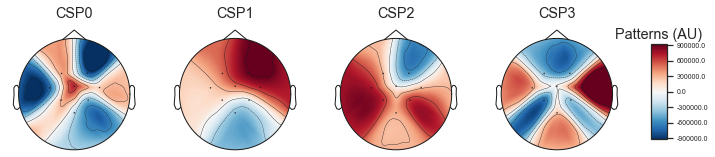

x_csp shape:  (720, 4)
x_raw_csp shape:  (720, 4)
All data shape:  (720, 701)
Just stats shape:  (720, 8)


In [319]:
# This is the PSD data
x = create_data(selected_electrodes_ref.T, fs, n_samples, low, high, n_freqs, zeros, length) 
print("Final data shape: " + str(x.shape))

# PSD data put through a normal transformation
quantile_transformer = QuantileTransformer(random_state=0).fit(x)
x_gaussian = quantile_transformer.transform(x)
print("x_gaussian shape: ", x_gaussian.shape)

# Reshape the PSD data for CSP
print(x.shape)
x_reshaped = np.reshape(x, (n_samples, n_channels_ref, n_freqs))
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# CSP of the PSD data
x_csp = csp.fit_transform(x_reshaped, y)
# Traditional CSP of the raw data
x_raw_csp = csp.fit_transform(selected_electrodes_reshaped, y)

info = mne.create_info(selected_channels, sfreq=fs, ch_types='eeg')
info['description'] = 'My motor imagery dataset!'
info.set_montage('standard_1020')

epochs = mne.EpochsArray(selected_electrodes_reshaped, info)

# # Apply band-pass filter to the raw data
# epochs.filter(7., 36., fir_design='firwin', skip_by_annotation='edge')

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
print("x_csp shape: ", x_csp.shape)
print("x_raw_csp shape: ", x_raw_csp.shape)


# Calculate the variance of the raw EEG
x_raw_var = []
for i in range(selected_electrodes_ref_reshaped.shape[0]):
    x_raw_var.append(np.var(selected_electrodes_ref_reshaped[i, :], axis=1))
x_raw_var = np.array(x_raw_var)

# Calculate the average value of the absolute value of raw EEG
x_raw_mean = []
for i in range(selected_electrodes_ref_reshaped.shape[0]):
    x_raw_mean.append(np.mean(np.abs(selected_electrodes_ref_reshaped[i, :]), axis=1))
x_raw_mean = np.array(x_raw_mean)

# Calculate the raw EEG Slope Sign Changes 
x_raw_ssc = []
for i in range(selected_electrodes_ref_reshaped.shape[0]):
    x_raw_ssc.append(SSC(selected_electrodes_ref_reshaped[i, :, :]))
x_raw_ssc = np.squeeze(np.array(x_raw_ssc))


# A feature vector with all the information
x_all = np.hstack((x_gaussian, x_csp, x_raw_csp, x_raw_var, x_raw_mean, x_raw_ssc))
print("All data shape: ", x_all.shape)

# A feature vector with just statistics
x_stats = np.hstack((x_csp, x_raw_csp))
print("Just stats shape: ", x_stats.shape)

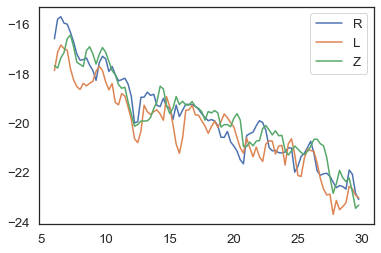

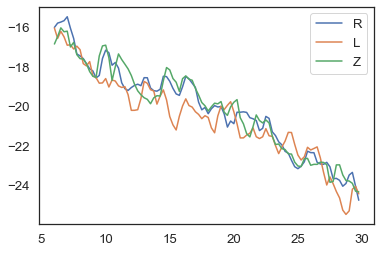

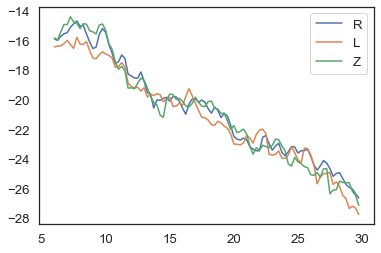

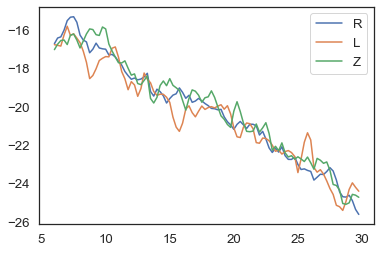

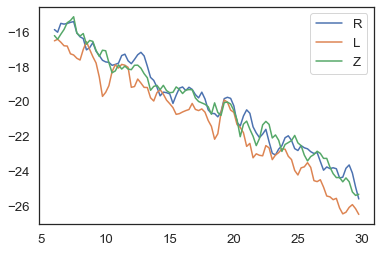

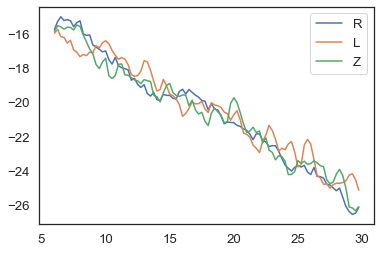

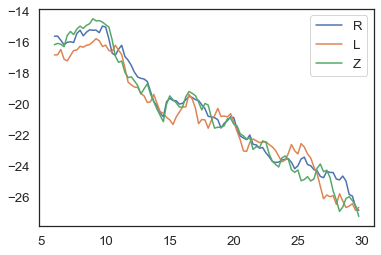

In [320]:
for i in range(selected_electrodes_ref.shape[0]):
    x_L = np.mean(x[0:int(n_samples/3), i*n_freqs:(i*n_freqs)+n_freqs], axis=0)
    x_R = np.mean(x[int(n_samples/3):2*int(n_samples/3), i*n_freqs:(i*n_freqs)+n_freqs], axis=0)
    x_Z = np.mean(x[2*int(n_samples/3):, i*n_freqs:(i*n_freqs)+n_freqs], axis=0)

    plt.figure()
    plt.plot(freqs_sliced, x_R)
    plt.plot(freqs_sliced, x_L)
    plt.plot(freqs_sliced, x_Z)
    plt.legend(['R', 'L', 'Z'])

In [321]:
def acc_cm(cm):
    cm = np.array(cm)
    total = 0
    for i in range(cm.shape[0]):
        total += cm[i][i]
    return total/np.sum(cm)

In [322]:
def run_test(model, select_dataset, y, cv_type, n_times, extra):
    total_scores = []
#     total_cm = np.array([[0,0,0], [0,0,0], [0,0,0]])
    total_cm = np.array([[0,0], [0,0]])

    for i in range(n_times):  
        total_cm += np.array(metrics.confusion_matrix(y, cross_val_predict(model, select_dataset, y, cv=cv_type)))

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(total_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {1}, {2}'.format("thingo", round(acc_cm(total_cm), 3), extra)
    plt.title(all_sample_title, size = 15);

In [323]:
cv_type = StratifiedKFold(10, shuffle=True)

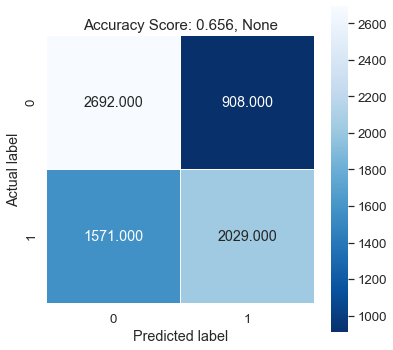

In [324]:
run_test(SVC(kernel='rbf'), x_stats, y,cv_type, n_times=10, extra=None)

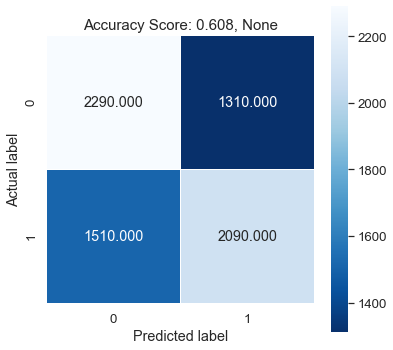

In [325]:
run_test(LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen'), x_stats, y,cv_type, n_times=10, extra=None)

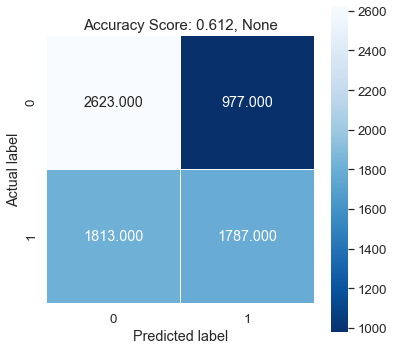

In [326]:
run_test(GaussianNB(), x_stats, y,cv_type, n_times=10, extra=None)

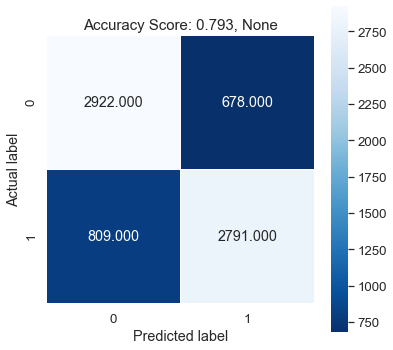

In [327]:
run_test(RandomForestClassifier(n_estimators=500, max_features="sqrt"), x_stats, y,cv_type, n_times=10, extra=None)

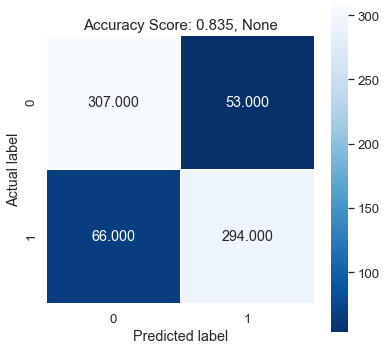

In [328]:
run_test(ExtraTreesClassifier(n_estimators=1000), x_stats, y,cv_type, n_times=1, extra=None)

In [272]:
# Feature importances
model = ExtraTreesClassifier(n_estimators=1000)
model.fit(x_gaussian, y)
print(model.feature_importances_)

[0.00126617 0.00086326 0.0011184  0.00180319 0.0007517  0.00125266
 0.00147748 0.00144792 0.00078707 0.00098546 0.00162297 0.00110264
 0.00162424 0.0010493  0.00100106 0.0011327  0.0022003  0.00166676
 0.0007136  0.0010426  0.00116298 0.00141817 0.001195   0.00132379
 0.00096828 0.00158411 0.00176353 0.00140639 0.00103798 0.00097342
 0.00143257 0.00131387 0.00103144 0.00090212 0.00158171 0.00172915
 0.00099014 0.00157164 0.00272391 0.00369635 0.00181222 0.0008706
 0.00107523 0.00125238 0.00127918 0.00131893 0.00142776 0.00127815
 0.0011853  0.00248189 0.00109517 0.00131021 0.0011832  0.00105951
 0.00100148 0.00106575 0.00119921 0.00140991 0.00113127 0.00104303
 0.00073755 0.00071223 0.00129533 0.00157707 0.00191939 0.00157006
 0.0012326  0.00168291 0.00134565 0.00119994 0.00224889 0.00138814
 0.00203059 0.00135224 0.00109012 0.0015408  0.00117842 0.0009925
 0.00080155 0.00133359 0.00115394 0.00109104 0.00117536 0.00063355
 0.00207577 0.00127987 0.00117494 0.00109092 0.00117136 0.001245

In [250]:
labels = []
for channel in selected_channels_ref:
    for i in np.linspace(1, 40, 157):
        labels.append(channel + "_" + str(i))

feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame(feature_importance, index=labels).T
feature_importance_df.head()

ValueError: Shape of passed values is (672, 1), indices imply (1099, 1)

In [251]:
frequencies = np.linspace(1, 40, 157)

avg_importance = np.mean(np.reshape(feature_importance, (7, 157)), axis=0)
plt.plot(frequencies, avg_importance)

# Find important electrodes
plt.figure()
channel_importance = np.mean(np.reshape(feature_importance, (7, 157)), axis=1)
plt.plot(selected_channels_ref, channel_importance)

ValueError: cannot reshape array of size 672 into shape (7,157)

In [23]:
# Export the trained model
import joblib

model = GaussianNB()
model.fit(x_csp, y)

x_csp = csp.fit_transform(x_reshaped, y)

filename = 'finalized_model.sav'

Computing rank from data with rank=None
    Using tolerance 25 (2.2e-16 eps * 7 dim * 1.6e+16  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 25 (2.2e-16 eps * 7 dim * 1.6e+16  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 25 (2.2e-16 eps * 7 dim * 1.6e+16  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


In [397]:
import operator

# Write a function that based on the classification ratio it will output 1 or 2 which
# corresponds to a hit
results = [0,1,1,1,1]

def define_result(results, threshold):
    classes = sorted(list(set(results)))
    predictions = {}
    
    for cls in classes:
        predictions[cls] = results.count(cls)

    dominant_class = max(predictions, key=predictions.get)
    if (predictions[dominant_class] / len(results)) >= threshold:
        return dominant_class
    else:
        return 0
    
define_result(results, 0.5)

1